In [1]:
import numpy as np
import time
import pandas as pd
from numba import njit, prange, types
import matplotlib.pyplot as plt
from tqdm import tqdm
from arch.unitroot import ADF
from numba.typed import Dict, List
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

### we use 2024 consumption electronics stock prices for back-testing

### pair trading strategy: $y = \alpha + \beta \cdot x + \epsilon$

<span style="font-size:16px;">Here y denotes the raw price(not log price) of stockY, x denotes the raw price(not log price) of stockX</span>

### rearrange the equation: $\epsilon = y - \beta \cdot x - \alpha$

<span style="font-size:16px;">if there is a stable relationship between the price of y and x as such, and the $\epsilon$ is mean-reverting in our time window, we can long the right-hand side portfolio when $\epsilon$ is low and short the right-hand side portfolio when $\epsilon$ is high, expecting that it will revert to the mean value and we can take profit. </span>


### 1. First, we need to run OLS to estimate $\alpha$ and $\beta$ series, and test whether the series are stable.

$$
\begin{bmatrix} \alpha \\ \beta \end{bmatrix}
= \left( \mathbf{X}^T \mathbf{X} \right)^{-1} \mathbf{X}^T \mathbf{y}
$$

<span style="font-size:16px;">where：</span>

$$
\mathbf{X} = \begin{bmatrix}
1 & x_1 \\
1 & x_2 \\
\vdots & \vdots \\
1 & x_n
\end{bmatrix}
$$

### 2. Next, we use variation coefficient and ADF test with intercept to test the stability of $\alpha$ and $\beta$ series

$$
\text{Variation Coefficient (CV)} = \frac{\sigma}{\mu}
$$

<span style="font-size:16px;">ADF test:</span>
$$
\Delta \alpha_t = c_\alpha + \rho_1 \alpha_{t-1} + \sum_{i=1}^{p} \gamma_{1i} \Delta \alpha_{t-i} + \epsilon_{1t}
$$
$$
\Delta \beta_t = c_\beta + \rho_2 \beta_{t-1} + \sum_{i=1}^{p} \gamma_{2i} \Delta \beta_{t-i} + \epsilon_{2t}
$$

<span style="font-size:16px;">we test whether $\rho$ is significantly less than 0, otherwise there is unit root and is non-stationary.</span>

### 3. Then we calculate the $\epsilon$ sequence in the regression window using the smoothed $\alpha$ and $\beta$ and use ADF test with no intercept and no time trend to test whether it is stationary with mean zero.

$$
\epsilon_t = y_t - \hat{\beta}_t x_t - \hat{\alpha}_t
$$

$$
\Delta \epsilon_t = \rho \epsilon_{t-1} + \sum_{i=1}^{p} \gamma_i \Delta \epsilon_{t-i} + e_t
$$
<span style="font-size:16px;">there is no intercept nor time trend in this ADF test because we expect the $\epsilon$ to be stationary with mean zero with no time trend.</span>

### 4. If the pair passes all these stability tests, we will construct four factors for the pair. First we MLE method to calibrate the O-U process of the residual sequence.

<span style="font-size:16px;"> OU Process: </span>
$$
dX_t = \lambda (\mu - X_t) dt + \sigma dW_t
$$
<span style="font-size:16px;"> where $\mu$ is the long term trend, $\lambda$ is the mean-reverting rate. and $\sigma$ is the volatility of random term. $dW_t$ is Brownian Motion </span>

$$
S_{t+1} = S_t e^{-\lambda \delta} + \mu (1 - e^{-\lambda \delta}) + \sigma \sqrt{\frac{1 - e^{-2\lambda \delta}}{2\lambda}} N_{0,1}
$$
<span style="font-size:16px;"> here $\delta$ denotes the time interval of each time step. in our pair-trading strategy we use daily price and this term is one. </span>

$$
P(N_{0,1} = x) = \frac{1}{\sqrt{2\pi}} e^{-\frac{1}{2} x^2}
$$


<span style="font-size:16px;"> conditional probability density function:</span>
$$
f(S_{t+1} | S_t; \mu, \lambda, \hat{\sigma}) = \frac{1}{\sqrt{2\pi \hat{\sigma}^2}} \exp\left[ -\frac{\left( S_t - S_{t-1} e^{-\lambda \delta} - \mu (1 - e^{-\lambda \delta}) \right)^2}{2 \hat{\sigma}^2} \right]
$$
<span style="font-size:16px;"> with:</span>
$$
\hat{\sigma}^2 = \sigma^2 \frac{1 - e^{-2\lambda \delta}}{2\lambda}
$$
<span style="font-size:16px;"> the log-likelihood function is:</span>
$$
\mathcal{L}(\mu, \lambda, \hat{\sigma}) = \sum_{t=1}^{n} \ln f(S_t, S_{t-1}; \mu, \lambda, \sigma)
$$

$$
= -\frac{n}{2} \ln(2\pi) - n \ln(\hat{\sigma})
$$

$$
- \frac{1}{2\hat{\sigma}^2} \sum_{t=1}^{n} \left[ S_t - S_{t-1} e^{-\lambda \delta} - \mu(1 - e^{-\lambda \delta}) \right]^2
$$

<span style="font-size:16px;"> we omit the intermediate steps and reach the conclusion directly:</span>


$$
\mu = \frac{S_y S_{xx} - S_x S_{xy}}{n(S_{xx} - S_{xy}) - (S_x^2 - S_x S_y)}
$$

$$
\lambda = -\frac{1}{\delta} \ln \frac{S_{xy} - \mu S_x - \mu S_y + n\mu^2}{S_{xx} - 2\mu S_x + n\mu^2}
$$

$$
\hat{\sigma}^2 = \frac{1}{n} \left[ S_{yy} - 2\alpha S_{xy} + \alpha^2 S_{xx} - 2\mu(1-\alpha)(S_y - \alpha S_x) + n\mu^2 (1-\alpha)^2 \right]
$$

$$
\sigma^2 = \hat{\sigma}^2 \frac{2\lambda}{1 - \alpha^2}
$$

$$
\alpha = e^{-\lambda \delta}
$$

<span style="font-size:16px;">where: </span>
$$
S_x = \sum_{t=1}^{n} S_{t-1}
$$

$$
S_y = \sum_{t=1}^{n} S_t
$$

$$
S_{xx} = \sum_{t=1}^{n} S_{t-1}^2
$$

$$
S_{xy} = \sum_{t=1}^{n} S_{t-1} S_t
$$

$$
S_{yy} = \sum_{t=1}^{n} S_t^2
$$
<span style="font-size:16px;">following these formula we manually write codes to calibrate the three parameters without using any python statistics package.</span>

### 5. After parameter calibration we simulate 1000 paths for pairs passing the tests above, and average the returns as the expected return. 

### 6. Combining z-score, standard deviation of residual sequence, expected return and probability of crossing take-profit boundary, we give a score for each pair, and rank potential pairs by this score.

## Trade:

<span style="font-size:16px;">1. At the start of trading day t, we first clear positions in the pairs_to_clear Dict, then open positions in the pairs_to_open Dict. Both Dicts are generated on day t-1 using t-1 signals. But trades are executed using day t open price. We take into account transaction costs.</span><br><br>
<span style="font-size:16px;">2. At the end of trading day t, we calculate the portfolio value using close price, and add cash to get the total value and record it. At the same time we sift out pairs that have reached either cutting-loss bound or take-profit bound, add them to the pairs_to_clear Dict to clear them next day.</span><br><br>
<span style="font-size:16px;">3. Based on day t's signals, we rank potential pairs according to their overall factor value, decide on which pairs in curr_holding to clear, and which pairs we should open on the next day.</span><br><br>
<span style="font-size:16px;">4. Transaction cost is set to be 0.05%</span>

In [2]:
price_data = pd.read_csv("./stock_price_885800TI.csv")
IN_SAMPLE_DATE_CUT = 20231231
OPEN, CLOSE, ADJUSTED_OPEN, ADJUSTED_CLOSE, ADJUSTED_OPEN_FORWARD, ADJUSTED_CLOSE_FORWARD = 0, 1, 2, 3, 4, 5
in_sample_data = price_data[price_data["trade_date"] <= IN_SAMPLE_DATE_CUT]
out_of_sample_data = price_data[price_data["trade_date"] > IN_SAMPLE_DATE_CUT]

In [3]:
corr_matrix = in_sample_data.pivot_table(index="trade_date", columns="ts_code", values="close_qfq").corr()
mean_corr = corr_matrix.mean(axis=1)
top_50_assets = mean_corr.sort_values(ascending=False).head(50)
top_50_assets_list = top_50_assets.index.tolist()
filtered_out_of_sample_data = out_of_sample_data[out_of_sample_data['ts_code'].isin(top_50_assets_list)]

In [4]:
# Input: DataFrame
# Output: 1. data_matrix: (T,N,D)   stock_codes: N    trade_dates: 
def pre_process(price_data):
    stock_codes = price_data["ts_code"].drop_duplicates().to_list()
    trade_dates = sorted(price_data["trade_date"].drop_duplicates().to_list())

    date_to_index = {date: i for i, date in enumerate(trade_dates)}
    stock_to_index = {stock: i for i, stock in enumerate(stock_codes)}
    T = len(trade_dates)
    N = len(stock_codes)
    D = 6
    tensor = np.full((T,N,D), np.nan)

    for _, row in price_data.iterrows():
        t_idx = date_to_index[row['trade_date']]
        n_idx = stock_to_index[row['ts_code']]
        tensor[t_idx, n_idx, :] = [row['open'], row['close'], row['open_hfq'], row['close_hfq'], row["open_qfq"], row["close_qfq"]]
    return tensor, trade_dates, stock_codes

In [5]:
data_matrix, trade_dates, stock_codes = pre_process(filtered_out_of_sample_data)

The tensor dimensions are represented as $T \times N \times D$, where:
- $T$: Time Steps
- $N$: Stock Num
- $D$: Stock Info

Here D = 6, and the four dimensions are open price, close price, adjusted open price, adjusted close price, forward-adjusted open price, forward-adjusted close price.<br>
N = 50, we filter the top 50 stocks whose average correlation with other stocks are highest.<br>
T = 242, we use one-year's data as the out-of-sample data.

In [6]:
@njit
def ols_fit(X, y):
    X_reshaped = np.ascontiguousarray(X).reshape(-1, 1)
    y_reshaped = np.ascontiguousarray(y).reshape(-1, 1)
    n_samples = X_reshaped.shape[0]
    ones = np.ones((n_samples, 1), dtype=np.float64)
    X_with_intercept = np.concatenate((ones, X_reshaped), axis=1)
    XTX = X_with_intercept.T @ X_with_intercept
    XTy = X_with_intercept.T @ y_reshaped
    beta = np.linalg.solve(XTX, XTy)
    return beta


# Input: residual sequence and dt
# Output: calibrated OU-process μ, σ, λ
@njit
def ou_calibrate_mle(S, delta):
    n = float(len(S) - 1)
    Sx = np.sum(S[:-1])
    Sy = np.sum(S[1:])
    Sxx = np.sum(S[:-1]**2)
    Sxy = np.sum(S[:-1] * S[1:])
    Syy = np.sum(S[1:]**2)

    # MLE estimation of parameters
    μ = (Sy*Sxx-Sx*Sxy)/(n*(Sxx-Sxy)-(Sx*Sx-Sx*Sy))
    λ = -np.log((Sxy-μ*Sx-μ*Sy+n*μ*μ)/(Sxx-2*μ*Sx+n*μ*μ)) / delta
    α = np.exp(-λ*delta)
    σ_square_estimate = (Syy-2*α*Sxy+α*α*Sxx-2*μ*(1-α)*(Sy-α*Sx)+n*μ*μ*(1-α)*(1-α)) / n
    σ = np.sqrt(σ_square_estimate*2*λ/(1-α*α))
    
    return μ, σ, λ

# Input: μ, σ, λ calibrated O-U process parameters; curr_pos: current dislocation; sigma: std of residual
# Ouput: estimation of probability of profitting, expected return, probability of cutting loss using 1000 simulated paths
@njit(parallel=True)
def simulate_expectation(curr_pos, μ, σ, λ, sigma, committed_capital,cutting_loss_bound,taking_profit_bound, trading_days_per_year=256):
    upper_boundary = cutting_loss_bound*sigma
    lower_boundary = taking_profit_bound*sigma
    dt = 1
    T = 100
    path_num = 1000
    curr_pos = abs(curr_pos)
    noise = np.random.normal(0, 1, size=(path_num, T))
    
    cross_type = np.zeros(path_num, dtype=np.int32)        # 0: none, 1: lower, 2: upper
    value_changes = np.zeros(path_num, dtype=np.float64)
    
    X = np.zeros((path_num, T+1))
    X[:, 0] = curr_pos
    # simulate the paths
    for t in range(1, T+1):
        X[:, t] = X[:, t-1]*np.exp(-λ*dt) + μ*(1-np.exp(-λ*dt)) + σ*np.sqrt((1-np.exp(-2*λ*dt))/(2*λ))*noise[:, t-1]
    # calculate the statistics we need
    for p in prange(path_num):
        path = X[p, :]
        for t in range(1, T+1):
            if path[t] > upper_boundary:
                cross_type[p] = 2
                value_changes[p] = (path[0]-path[t])/t
                break
            elif path[t] < lower_boundary:
                cross_type[p] = 1
                value_changes[p] = (path[0] - path[t])/t
                break
        if cross_type[p] == 0:
            value_changes[p] = (path[0] - path[T])/T
    probability_take_profit = np.sum(cross_type == 1) / path_num
    probability_cut_loss = np.sum(cross_type == 2) / path_num
    expected_profit = np.mean(value_changes) / committed_capital * trading_days_per_year
    return probability_take_profit, expected_profit, probability_cut_loss

In [7]:
@njit
def rss_single(sequence):
    mean_val = np.mean(sequence)
    residuals = sequence-mean_val
    return np.sum(residuals*residuals)

@njit
def rss_two_means(sequence, break_point):
    s1 = sequence[:break_point]
    s2 = sequence[break_point:]
    mean1 = np.mean(s1)
    mean2 = np.mean(s2)
    rss1 = np.sum((s1 - mean1) ** 2)
    rss2 = np.sum((s2 - mean2) ** 2)
    return rss1 + rss2

@njit
def chow_break_f_statistic(series, break_point, sse_r):
    n = series.size
    sse_12 = rss_two_means(series, break_point)

    k = 2
    numerator = (sse_r - sse_12) / k
    denominator = sse_12 / (n - 2*k)
    if denominator <= 1e-14:
        return 0.0
    F_stat = numerator / denominator
    return F_stat

@njit
def chow_structural_change_test(sequence):
    n = sequence.size
    
    f_sequence = np.zeros(n-1)
    sse_r = rss_single(sequence)
    for b in range(1, n):
        f_sequence[b-1] = chow_break_f_statistic(sequence, b, sse_r)
    f_statistic = np.max(f_sequence)
    return f_statistic

In [15]:
SIGNAL_NUM = 10
OPEN = 0
EXPECTED_RETURN = 1
PROBABILITY_OF_PROFIT = 2
ALPHA = 3
BETA = 4
RESIDUAL_SIGMA = 5
Z_SCORE = 6
VALIDITY = 7
DISLOCATION = 8
PROFITING_PERCENTAGE = 9
trading_days_per_year = 256
trade_dates = np.array(trade_dates)
stock_codes = np.array(stock_codes)
transaction_cost = 0.0005
@njit
def initAlphaBetaSequence(trade_dates, stock_codes, alpha_sequence, beta_sequence,start_date_idx,smoothing_window,regression_window):
    n_trade_dates = trade_dates.size
    n_stocks = stock_codes.size
    for t in range(start_date_idx-smoothing_window+1,n_trade_dates):
        for stockY in range(n_stocks):
            for stockX in range(stockY+1, n_stocks):
                Y = data_matrix[t-regression_window+1: t+1, stockY, ADJUSTED_CLOSE_FORWARD]
                X = data_matrix[t-regression_window+1: t+1, stockX, ADJUSTED_CLOSE_FORWARD]
                param = ols_fit(X, Y)
                alpha_sequence[t, stockY, stockX] = param[0,0]
                beta_sequence[t, stockY, stockX] = param[1,0]
                
                
@njit
def alphaBetaSequenceTest(trade_dates, stock_codes, alpha_sequence, beta_sequence, signals,start_date_idx,
                         vc_threshold,smoothing_window):
    n_trade_dates = trade_dates.size
    n_stocks = stock_codes.size
    for t in range(start_date_idx, n_trade_dates):
        for stockY in range(n_stocks):
            for stockX in range(stockY+1, n_stocks):
                alpha_series = alpha_sequence[t-smoothing_window+1:t+1,stockY, stockX]
                beta_series = beta_sequence[t-smoothing_window+1:t+1, stockY, stockX]
#                 alpha_f_statistic = chow_structural_change_test(alpha_series)        
#                 beta_f_statistic = chow_structural_change_test(beta_series)
                
                if np.min(beta_series) <= 0 or abs(np.mean(alpha_series))<0.1:
                    signals[t,stockY,stockX, VALIDITY] = 0
#                 if (alpha_f_statistic < f_threshold) and (beta_f_statistic < f_threshold):
#                     signals[t,stockY,stockX, VALIDITY] = 1
                else:
                    alpha_vc = np.std(alpha_series)/np.mean(alpha_series)
                    beta_vc = np.std(beta_series)/np.mean(beta_series)
                    if beta_vc < vc_threshold and abs(alpha_vc) < vc_threshold:
                        signals[t,stockY,stockX, VALIDITY] = 1
                    else:
                        signals[t,stockY,stockX, VALIDITY] = 0

# generate trading signals
def generateSignals(bound,alpha_sequence, beta_sequence,signals, start_date_idx,smoothing_window,regression_window,adf_p_threshold,
                   cutting_loss_bound,taking_profit_bound):
    # generate trading signals for each day according to the forward-adjusted close prices
    for t in range(start_date_idx, len(trade_dates)):
        mask = signals[t,:,:,VALIDITY] == 1
        indices = np.where(mask)
        index_list = list(zip(indices[0], indices[1]))
        # generate trading signals for each pair
        for stockY, stockX in index_list:
            alpha_series = alpha_sequence[t-smoothing_window+1:t+1,stockY, stockX]
            beta_series = beta_sequence[t-smoothing_window+1:t+1,stockY, stockX]
            
            alpha_adf_r = ADF(alpha_series, lags=None, trend="c")
            beta_adf_r = ADF(beta_series, lags=None, trend="c")
            if (alpha_adf_r.pvalue <= adf_p_threshold) and (beta_adf_r.pvalue <= adf_p_threshold):
                Y = data_matrix[t-regression_window+1:t+1,stockY, ADJUSTED_CLOSE_FORWARD]
                X = data_matrix[t-regression_window+1:t+1,stockX, ADJUSTED_CLOSE_FORWARD]
                smoothed_alpha = np.mean(alpha_series)
                smoothed_beta = np.mean(beta_series)
                residual = Y - smoothed_beta*X - smoothed_alpha
                residual_adf_result = ADF(residual, lags=None, trend="n")
                # test whether the residual series is stationary around zero
                if residual_adf_result.pvalue <= adf_p_threshold:
                    sigma = np.std(residual)                
                    y_pt = data_matrix[t, stockY,ADJUSTED_CLOSE_FORWARD]
                    x_pt = data_matrix[t, stockX,ADJUSTED_CLOSE_FORWARD]
                    dislocation = y_pt - smoothed_beta*x_pt - smoothed_alpha
                    z_score = dislocation / sigma
                    # dislocation crosses beyond open bound, set open = 1
                    if abs(z_score) > bound:
                        μ, σ, λ = ou_calibrate_mle(residual, 1)
                        commmited_capital = y_pt + smoothed_beta*x_pt
                        pp, ee, pl = simulate_expectation(dislocation, μ, σ, λ, sigma, commmited_capital,cutting_loss_bound,taking_profit_bound)
                        if ee > 0:
                            if (z_score > 0):
                                percentage = np.sum(residual<taking_profit_bound*sigma)/regression_window
                            if (z_score < 0):
                                percentage = np.sum(residual>-taking_profit_bound*sigma)/regression_window
                            signals[t, stockY, stockX, PROFITING_PERCENTAGE] = percentage
                            signals[t, stockY, stockX, DISLOCATION] = dislocation
                            signals[t, stockY, stockX, OPEN] = 1
                            signals[t, stockY, stockX, RESIDUAL_SIGMA] = sigma
                            signals[t, stockY, stockX, Z_SCORE] = z_score
                            signals[t, stockY, stockX, ALPHA] = smoothed_alpha
                            signals[t, stockY, stockX, BETA] = smoothed_beta
                            signals[t, stockY, stockX, PROBABILITY_OF_PROFIT] = pp
                            signals[t, stockY, stockX, EXPECTED_RETURN] = ee
                        else:
                            signals[t, stockY, stockX, OPEN] = 0
                    else:
                        signals[t, stockY, stockX, OPEN] = 0
                else:
                    signals[t, stockY, stockX, OPEN] = 0
            else:
                signals[t,stockY,stockX, VALIDITY] = 0

In [16]:
# some statistics
COUNT_TAKE_PROFIT = 0
COUNT_CUT_LOSS = 1

# key: (stockY, stockX)
# value: (dislocation, beta, alpha, commitedCapital)
OPEN_DISLOCATION = 0
OPEN_BETA = 1
OPEN_ALPHA = 2
OPEN_COMMITED_CAPITAL = 3
OPEN_AMOUNT = 4
OPEN_SIGMA = 5

@njit
def trade(signals, trade_info, curr_holding, pairs_to_clear, pairs_to_open, capital,start_date_idx,
        data_matrix, cutting_loss_bound,taking_profit_bound,max_pairs ):
    # cash: cash holding; pairs_holding: value of curr_holding pairs
    cash = capital
    pairs_holding = 0
    n_trade_dates = trade_dates.size
    n_stocks = stock_codes.size
    
    capital_sequence = np.zeros(n_trade_dates-start_date_idx)
    for t in range(start_date_idx, n_trade_dates):
        # check pairs_to_trade, and trade according to the order
        pairs_to_clear_keys = list(pairs_to_clear.keys())
        pairs_to_open_keys = list(pairs_to_open.keys())
        for stockY, stockX in pairs_to_clear:
            (open_amount, open_beta) = pairs_to_clear[(stockY, stockX)]
            y_pt = data_matrix[t, stockY, ADJUSTED_OPEN_FORWARD]
            x_pt = data_matrix[t, stockX, ADJUSTED_OPEN_FORWARD]
            
            pair_value = y_pt - open_beta*x_pt
            pair_price = y_pt + open_beta*x_pt
          
            cash = cash + pair_value*open_amount - abs(transaction_cost*pair_price*open_amount)
        for stockY, stockX in pairs_to_clear_keys:
            del pairs_to_clear[(stockY, stockX)]
        
        
        curr_holding_num = len(curr_holding.keys())
        if len(pairs_to_open_keys) != 0:
            cash_per_pair = cash / (max_pairs-curr_holding_num)
            for stockY, stockX in pairs_to_open:
                y_pt = data_matrix[t, stockY, ADJUSTED_OPEN_FORWARD]
                x_pt = data_matrix[t, stockX, ADJUSTED_OPEN_FORWARD]
                dislocation = signals[t-1, stockY, stockX, DISLOCATION]
                beta = signals[t-1,stockY, stockX, BETA]
                alpha = signals[t-1,stockY, stockX, ALPHA]
                price_per_pair = y_pt + beta*x_pt
                sigma = signals[t-1,stockY, stockX, RESIDUAL_SIGMA]

                if dislocation > 0:
                    amount = -cash_per_pair / price_per_pair
                if dislocation < 0:
                    amount = cash_per_pair / price_per_pair
                pair_value = y_pt - beta*x_pt
                pair_price = y_pt + beta*x_pt
                cash = cash - amount*pair_value - abs(amount*pair_price*transaction_cost)
                curr_holding[(stockY, stockX)] = (dislocation, beta, alpha, cash_per_pair,amount,sigma)
            for stockY, stockX in pairs_to_open_keys:
                del pairs_to_open[(stockY, stockX)]
            
        # calculate portfolio value at the end of the trading day
        pairs_holding = 0
        # for pairs in curr_holding, check whether to cut loss or take profit
        for stockY, stockX in curr_holding:
            open_dislocation, open_beta, open_alpha, open_commited_capital, open_amount, open_sigma = curr_holding[(stockY,stockX)]
            y_pt = data_matrix[t, stockY, ADJUSTED_CLOSE_FORWARD]
            x_pt = data_matrix[t, stockX, ADJUSTED_CLOSE_FORWARD]
            
            # use current price, and open alpha/beta  to be comparable to open_dislocation
            pair_value = y_pt - open_beta*x_pt
            pairs_holding += open_amount*pair_value
            
            curr_dislocation = pair_value - open_alpha
            if open_dislocation > 0:
                if curr_dislocation > cutting_loss_bound*open_sigma:
                    pairs_to_clear[(stockY, stockX)] = (open_amount, open_beta)
                    trade_info[COUNT_CUT_LOSS] += 1
                if curr_dislocation < taking_profit_bound*open_sigma:
                    pairs_to_clear[(stockY, stockX)] = (open_amount, open_beta)
                    trade_info[COUNT_TAKE_PROFIT] += 1
            
            if open_dislocation < 0:
                if curr_dislocation < -cutting_loss_bound*open_sigma:
                    pairs_to_clear[(stockY, stockX)] = (open_amount, open_beta)
                    trade_info[COUNT_CUT_LOSS] += 1
                if curr_dislocation > -taking_profit_bound*open_sigma:
                    pairs_to_clear[(stockY, stockX)] = (open_amount, open_beta)
                    trade_info[COUNT_TAKE_PROFIT] += 1
                    
        capital_sequence[t-start_date_idx] = cash+pairs_holding
        # delete pair in pairs_to_clear from curr_holding            
        for stockY, stockX in pairs_to_clear:
            del curr_holding[(stockY, stockX)]
        
        # find potential pairs to trade:
        # 1. not in curr_holding
        # 2. open is 1
        indices = np.argwhere(signals[t,:,:,OPEN]==1)
        
        # pairs_pool:  pairs whose current open is 1 UNION curr_holding
        pairs_pool = np.zeros((indices.size+max_pairs, 2), dtype=np.int64)
        sz = 0
        for stockY, stockX in curr_holding:
            pairs_pool[sz, 0] = stockY
            pairs_pool[sz, 1] = stockX
            sz += 1
        for stockY, stockX in indices:
            if (stockY, stockX) not in curr_holding:
                pairs_pool[sz, 0] = stockY
                pairs_pool[sz, 1] = stockX
                sz += 1
        pairs_pool = pairs_pool[:sz, :]
        pair_num = pairs_pool.shape[0]
        
        # pairs in pool less than or equal max_pairs, set target pairs
        if pair_num <= max_pairs:
            target_pairs = pairs_pool
        # pairs in pool more than max_pairs, select pairs with highest scores
        else:
            scoring_matrix = np.zeros((pair_num, 4))
            for i in range(pair_num):
                # use expected return, abosolute value of zscore and pair residual volatility as scoring metric
                stockY, stockX = pairs_pool[i]
                scoring_matrix[i, 0] = signals[t, stockY, stockX, EXPECTED_RETURN]
                scoring_matrix[i, 1] = abs(signals[t, stockY, stockX, Z_SCORE])
                scoring_matrix[i, 2] = signals[t, stockY, stockX, RESIDUAL_SIGMA]
                scoring_matrix[i, 3] = signals[t, stockY, stockX, PROFITING_PERCENTAGE]
            scoring_mean = scoring_matrix.sum(axis=0) / pair_num
            scoring_std = np.sqrt(np.sum((scoring_matrix-scoring_mean)**2, axis=0)/pair_num)
            normalized_score = (scoring_matrix-scoring_mean)/scoring_std
            scores = np.sum(normalized_score, axis=1)
            target_pairs_idx = np.argsort(scores)[-max_pairs:][::-1]
            target_pairs = np.zeros((max_pairs, 2), dtype=np.int64)
            for i in range(max_pairs):
                pair_idx = target_pairs_idx[i]
                y, x = pairs_pool[pair_idx]
                target_pairs[i, 0] = y
                target_pairs[i, 1] = x
        for stockY, stockX in target_pairs:
            if (stockY, stockX) not in curr_holding:
                pairs_to_open[(stockY, stockX)] = t
        for stockY, stockX in curr_holding:
            exist = False
            for y,x in target_pairs:
                if y==stockY and x==stockX:
                    exist = True
                    break
            if not exist:
                _, open_beta, _, _, open_amount, _ = curr_holding[(stockY,stockX)]
                pairs_to_clear[(stockY, stockX)] = (open_amount, open_beta)
        for stockY, stockX in pairs_to_clear:
            if (stockY, stockX) in curr_holding:
                del curr_holding[(stockY, stockX)]
    return capital_sequence

In [17]:
def simulate_trade(data_matrix, trade_dates, stock_codes, smoothing_window=10, regression_window=30, bound=2.0, 
                   cutting_loss_bound=3.5, taking_profit_bound=0.5, adf_p_threshold=0.05,
                   vc_threshold=0.3, max_pairs=10):
    capital = 10000000
    T, N, D = data_matrix.shape
    alpha_sequence = np.full((T, N, N), np.nan)
    beta_sequence = np.full((T, N, N), np.nan)
    signals = np.zeros((T, N, N, SIGNAL_NUM))
    curr_holding = Dict.empty(key_type=types.Tuple((types.int64, types.int64)), value_type=types.Tuple((types.float64, types.float64, types.float64, types.float64, types.float64,types.float64)))
    pairs_to_clear = Dict.empty(key_type=types.Tuple((types.int64, types.int64)), value_type=types.Tuple((types.float64, types.float64)))
    pairs_to_open = Dict.empty(key_type=types.Tuple((types.int64, types.int64)), value_type=types.int64)
    
    start_date_idx = smoothing_window + regression_window - 2
    
    initAlphaBetaSequence(trade_dates, stock_codes, alpha_sequence, beta_sequence,start_date_idx,smoothing_window,regression_window)
    alphaBetaSequenceTest(trade_dates, stock_codes, alpha_sequence, beta_sequence, signals,start_date_idx,
                         vc_threshold,smoothing_window)
    trade_info = np.zeros(4)
    generateSignals(bound, alpha_sequence, beta_sequence, signals,start_date_idx,smoothing_window,regression_window,adf_p_threshold,
                   cutting_loss_bound, taking_profit_bound)
   
    sequence = trade(signals, trade_info, curr_holding, pairs_to_clear, pairs_to_open, capital,
                start_date_idx,data_matrix,cutting_loss_bound,taking_profit_bound,max_pairs)
    return sequence

In [18]:
sequence = simulate_trade(data_matrix, trade_dates, stock_codes)

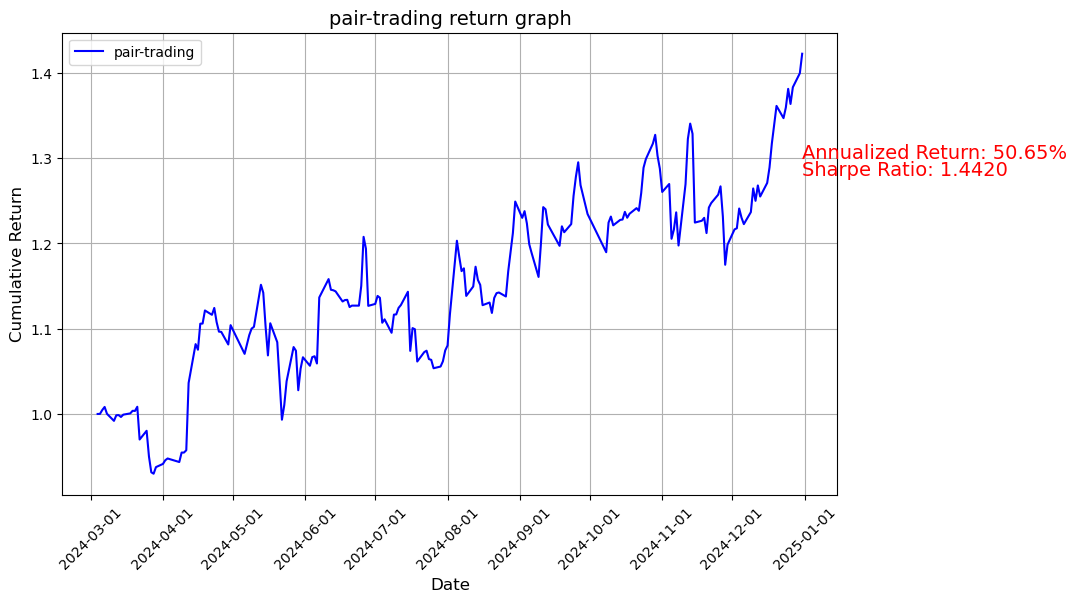

In [19]:
returns = sequence / sequence[0]
value_changes = sequence[1:] - sequence[:-1]
daily_return = value_changes / sequence[:-1]
annualized_std = np.std(daily_return) * np.sqrt(trading_days_per_year)
annualized_return = np.mean(daily_return) * trading_days_per_year
sharpe_ratio = annualized_return / annualized_std

time = trade_dates[-sequence.size:]
dates = pd.to_datetime(time, format='%Y%m%d')

plt.figure(figsize=(10, 6))
plt.plot(dates, returns, label="pair-trading", color='blue')

plt.title("pair-trading return graph", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Cumulative Return", fontsize=12)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()

plt.text(dates[-1], 1.3, f"Annualized Return: {annualized_return * 100:.2f}%", fontsize=14, color='red')
plt.text(dates[-1], 1.28, f"Sharpe Ratio: {sharpe_ratio:.4f}", fontsize=14, color='red')

plt.show()

## References

1. Thijs van den Berg (2011) Calibrating the Ornstein-Uhlenbeck (Vasicek) model<br>
2. Financial-Models-Numerical-Methods  https://github.com/cantaro86/Financial-Models-Numerical-Methods/blob/master/6.1%20Ornstein-Uhlenbeck%20process%20and%20applications.ipynb